In [1]:
import os

import matplotlib.pyplot
import matplotlib.pyplot as plt
import numpy
import numpy as np
import pandas
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import umap
from matplotlib.colors import LogNorm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (adjusted_rand_score, completeness_score,
                             homogeneity_score, mean_absolute_error,
                             normalized_mutual_info_score, r2_score,
                             silhouette_score)
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.benchmark = True

import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

import torch.multiprocessing as mp

mp.set_start_method("spawn", force=True)

name = "Huber2"

In [2]:
%load_ext autoreload
%autoreload 2

from utils import *
from VAE_GDSC import GDSCDataset, GeneDrugVAE

In [3]:
cellline = pd.read_csv(
    "../dataset/gdsc/cellline_info.csv.gz",
    usecols=["COSMIC_ID", "SMILES", "NAME", "Z_score"],
)
exp = pd.read_csv("../dataset/gdsc/exp.csv.gz", index_col=0)

In [4]:
# 学習済みモデルの指定（ChemBERTa）
MODEL_NAME = "seyonec/ChemBERTa-zinc-base-v1"

# トークナイザーとモデルをロード
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

# GPUが使える場合はGPUに
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [5]:
smiles_list = cellline["SMILES"].unique().tolist()

inputs = tokenizer(smiles_list, padding=True, truncation=True, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :]  # [batch_size, hidden_size]

In [6]:
drugs = pd.DataFrame(embeddings.cpu().numpy())
drugs.index = smiles_list

In [7]:
exp.index = exp.index.astype(str)
cellline["COSMIC_ID"] = cellline["COSMIC_ID"].astype(str)
drugs.index = drugs.index.astype(str)

In [8]:
exp_values = exp.to_numpy(dtype=np.float32)
cid_to_row = {cid: i for i, cid in enumerate(exp.index)}
drug_vec = {s: drugs.loc[s].to_numpy(dtype=np.float32) for s in drugs.index}
mask = cellline["COSMIC_ID"].isin(exp.index) & cellline["SMILES"].isin(drugs.index)
cellline_small = cellline.loc[mask].reset_index(drop=True)
print(f"usable pairs: {len(cellline_small):,} / {len(cellline):,}")

usable pairs: 284,826 / 284,826


In [9]:
print("n_sample:", cellline_small.shape[0])

n_sample: 284826


In [10]:
# そのまま/変更案
batch_size = 16384
num_epochs = 100

# まずはこのセットで様子見（20–30 epoch）
rec_w = 0.2  # 再構成の重みをさらに下げる
lam = 3.0  # 10.0 → 3.0（目安: 2〜5）
beta_max = 1.0  # KLを抑える項は一旦オフ
gamma = 2.0  # C に寄せる圧を強化（いまの4倍）

C_max = 0.03  # 0.10 → 0.05
C_steps = 300  # 100 → 200

lr = 1e-3
weight_decay = 1e-3

In [11]:
ds = GDSCDataset(
    cellline_small,
    exp_values,
    cid_to_row,
    drug_vec,
    dtype=torch.float32,
    pin_memory=True,
    copy_arrays=False,
    #     materialize="none",    # ← これが重要！前展開を完全禁止
    #     ram_limit_gb=0.5       # （任意）auto を使う時の安全枠も小さくできる
)

In [12]:
val_ratio = 0.2
n_total = len(ds)
n_val = int(n_total * val_ratio)
n_train = n_total - n_val

# 再現性
g = torch.Generator().manual_seed(42)
train_ds, val_ds = random_split(ds, [n_train, n_val], generator=g)

In [13]:
train_dl = DataLoader(
    train_ds,
    batch_size=batch_size,  # GPU メモリに合わせて調整（8k〜32k 目安）
    shuffle=True,
    num_workers=1,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4,
    drop_last=True,
)

In [14]:
val_dl = DataLoader(
    val_ds,
    batch_size=batch_size,  # 余裕があれば少し大きめ
    shuffle=False,  # 検証はシャッフル不要
    num_workers=1,  # ここは少なめでもOK
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
    drop_last=False,
)

In [15]:
gene_dim = exp_values.shape[1]
smiles_dim = 768

device = (
    torch.device("cuda")
    if torch.cuda.is_available()
    else (
        torch.device("mps")
        if torch.backends.mps.is_available()
        else torch.device("cpu")
    )
)
device_type = (
    "cuda" if device.type == "cuda" else ("mps" if device.type == "mps" else "cpu")
)

use_amp = device_type in ("cuda", "mps")

# GradScaler は CUDA のみ
scaler = torch.amp.GradScaler(enabled=(device_type == "cuda"))

In [16]:
os.makedirs("models/gdsc", exist_ok=True)

best_val = float("inf")
best_path = f"models/gdsc/gdsc_best_{name}.pt"

# --- logs / histories ---
train_hist, val_hist, elbo_val_hist = [], [], []
train_rec_hist, train_kl_hist, train_z_hist = [], [], []
val_rec_hist, val_kl_hist, val_z_hist = [], [], []
train_capgap_hist, val_capgap_hist, C_values = [], [], []

model = GeneDrugVAE(
    gene_dim, drug_dim=smiles_dim, proj_dim=256, hidden=512, latent=128
).to(device)

# 1) Optimizer を param group で作り直し
head_params = list(model.head.parameters())
base_params = [p for n, p in model.named_parameters() if not n.startswith("head.")]

opt = torch.optim.Adam(
    [
        {"params": base_params, "lr": lr, "weight_decay": 1e-3},
        {"params": head_params, "lr": lr * 0.5, "weight_decay": 5e-3},  # ← LR↓, WD↑
    ]
)


def _avg(sum_val, cnt):
    return sum_val / max(cnt, 1)


beta_warmup_epochs = int(0.5 * num_epochs)
for ep in range(num_epochs):
    # === 追加：このepochのβ（0→1に線形） ===
    beta = beta_max * min(1.0, (ep + 1) / beta_warmup_epochs)

    model.train()
    C = C_max * (ep / C_steps) if ep < C_steps else C_max
    C_values.append(C)

    # ---- training ----
    m_total = n_batches = 0
    rec_sum = kl_sum = z_sum = capgap_sum = 0.0
    n_train_samples = 0

    for bidx, (xg, xd, y) in enumerate(
        tqdm(train_dl, desc=f"Train E{ep+1}", leave=False)
    ):
        if ep == 0 and bidx == 0:
            print(
                f"[LR] base={opt.param_groups[0]['lr']:.2e} | head={opt.param_groups[1]['lr']:.2e}"
            )

        xg = xg.to(device, non_blocking=True)
        xd = xd.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        opt.zero_grad(set_to_none=True)

        with torch.amp.autocast(device_type=device_type, enabled=use_amp):
            recon, mu, lv, yhat = model(xg, xd)
            rec = F.mse_loss(recon, xg, reduction="mean")
            kl = 0.5 * (-1 - lv + mu.pow(2) + lv.exp()).sum(dim=1).mean()
            zloss = F.smooth_l1_loss(yhat, y, beta=1, reduction="mean")  # Huber
            gap_abs = torch.abs(kl - C)
            gap_sq = (kl - C) ** 2
            loss = rec_w * rec + beta * kl + gamma * gap_sq + lam * zloss

        if device_type == "cuda":
            prev_scale = scaler.get_scale()
            scaler.scale(loss).backward()
            scaler.unscale_(opt)  # ← これを追加してからクリップ
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            scaler.step(opt)
            scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            opt.step()

        bs = xg.size(0)
        m_total += loss.item()
        n_batches += 1
        rec_sum += rec.item() * bs
        kl_sum += kl.item() * bs
        z_sum += zloss.item() * bs
        capgap_sum += gap_abs.item() * bs
        n_train_samples += bs

    train_loss = m_total / n_batches
    train_hist.append(train_loss)
    train_rec_hist.append(_avg(rec_sum, n_train_samples))
    train_kl_hist.append(_avg(kl_sum, n_train_samples))
    train_z_hist.append(_avg(z_sum, n_train_samples))
    train_capgap_hist.append(_avg(capgap_sum, n_train_samples))

    # ---- validation ----
    model.eval()
    val_loss_sum = 0.0
    n_val_batches = 0
    v_rec_sum = v_kl_sum = v_z_sum = v_capgap_sum = 0.0
    n_val_samples = 0
    elbo_val_sum = 0.0

    with torch.no_grad():
        for xg, xd, y in val_dl:
            xg, xd, y = xg.to(device), xd.to(device), y.to(device)
            recon, mu, lv, yhat = model(xg, xd)
            rec = F.mse_loss(recon, xg, reduction="mean")
            kl = 0.5 * (-1 - lv + mu.pow(2) + lv.exp()).sum(dim=1).mean()
            zloss = F.smooth_l1_loss(yhat, y, beta=1, reduction="mean")  # Huber
            gap_abs = torch.abs(kl - C)  # ← 追加：ログ用
            gap_sq = (kl - C) ** 2  # ← 追加：損失用（二乗）

            loss = rec_w * rec + beta * kl + gamma * gap_sq + lam * zloss
            elbo_loss = rec + beta * kl + lam * zloss

            bs = xg.size(0)
            val_loss_sum += loss.item()
            n_val_batches += 1
            v_rec_sum += rec.item() * bs
            v_kl_sum += kl.item() * bs
            v_z_sum += zloss.item() * bs
            v_capgap_sum += gap_abs.item() * bs  # ← 置換：capgap → gap_abs
            n_val_samples += bs
            elbo_val_sum += elbo_loss.item() * bs

    val_loss = val_loss_sum / n_val_batches
    val_hist.append(val_loss)
    val_rec_hist.append(_avg(v_rec_sum, n_val_samples))
    val_kl_hist.append(_avg(v_kl_sum, n_val_samples))
    val_z_hist.append(_avg(v_z_sum, n_val_samples))
    val_capgap_hist.append(_avg(v_capgap_sum, n_val_samples))
    elbo_val_hist.append(_avg(elbo_val_sum, n_val_samples))

    print(
        f"Epoch {ep+1}/{num_epochs} | Train {train_loss:.4f} | Val {val_loss:.4f} | Val(ELBO) {elbo_val_hist[-1]:.4f}"
    )

    print(
        f"  C={C:.3f} | "
        f"KL tr/val={train_kl_hist[-1]:.4f}/{val_kl_hist[-1]:.4f} | "
        f"gap(|KL-C|) tr/val={train_capgap_hist[-1]:.4f}/{val_capgap_hist[-1]:.4f} | "
        f"zloss tr/val={train_z_hist[-1]:.4f}/{val_z_hist[-1]:.4f} | "
        f"rec tr/val={train_rec_hist[-1]:.4f}/{val_rec_hist[-1]:.4f} | "
        f"beta={beta:.4f}, gamma={gamma:.4f}"
    )

    if (ep + 1) % 10 == 0:
        model.eval()
        eval_dl = torch.utils.data.DataLoader(
            val_ds,
            batch_size=8192,
            shuffle=False,
            num_workers=0,
            pin_memory=False,
            persistent_workers=False,
            drop_last=False,
        )
        ys, yhats = [], []
        with torch.inference_mode():
            for xg, xd, y in eval_dl:
                xg, xd = xg.to(device), xd.to(device)
                _, _, _, yhat = model(xg, xd)
                ys.append(y.cpu().numpy())
                yhats.append(yhat.cpu().numpy())
        import numpy as np
        from sklearn.metrics import mean_absolute_error, r2_score

        ys = np.concatenate(ys)
        yhats = np.concatenate(yhats)
        mae = mean_absolute_error(ys, yhats)
        r2 = r2_score(ys, yhats)
        print(f"  [Eval@E{ep+1}] MAE={mae:.4f}, R^2={r2:.4f}")
        print(f"  [Eval@E{ep+1}] yhat mean/std = {yhats.mean():.4f}/{yhats.std():.4f}")

    if val_loss < best_val - 1e-6:
        best_val = val_loss
        torch.save(model.state_dict(), best_path)
        print(f"[Save] Best model updated at epoch {ep+1}: {best_path}")

Train E1:   0%|          | 0/13 [00:00<?, ?it/s]

[LR] base=1.00e-03 | head=5.00e-04


Epoch 1/100 | Train 1.4473 | Val 1.3973 | Val(ELBO) 2.2007
  C=0.000 | KL tr/val=0.1004/0.0717 | gap(|KL-C|) tr/val=0.1004/0.0717 | zloss tr/val=0.4029/0.3945 | rec tr/val=1.0337/1.0158 | beta=0.0200, gamma=2.0000
[Save] Best model updated at epoch 1: models/gdsc/gdsc_best_Huber2.pt


Epoch 2/100 | Train 1.3544 | Val 1.3182 | Val(ELBO) 2.1047
  C=0.000 | KL tr/val=0.0909/0.0929 | gap(|KL-C|) tr/val=0.0908/0.0928 | zloss tr/val=0.3774/0.3657 | rec tr/val=1.0092/1.0040 | beta=0.0400, gamma=2.0000
[Save] Best model updated at epoch 2: models/gdsc/gdsc_best_Huber2.pt


Epoch 3/100 | Train 1.2822 | Val 1.2639 | Val(ELBO) 2.0487
  C=0.000 | KL tr/val=0.1045/0.0912 | gap(|KL-C|) tr/val=0.1043/0.0910 | zloss tr/val=0.3512/0.3475 | rec tr/val=1.0021/1.0008 | beta=0.0600, gamma=2.0000
[Save] Best model updated at epoch 3: models/gdsc/gdsc_best_Huber2.pt


Epoch 4/100 | Train 1.2390 | Val 1.2294 | Val(ELBO) 2.0103
  C=0.000 | KL tr/val=0.0964/0.0987 | gap(|KL-C|) tr/val=0.0961/0.0984 | zloss tr/val=0.3375/0.3341 | rec tr/val=1.0005/0.9999 | beta=0.0800, gamma=2.0000
[Save] Best model updated at epoch 4: models/gdsc/gdsc_best_Huber2.pt


Epoch 5/100 | Train 1.2126 | Val 1.2102 | Val(ELBO) 1.9978
  C=0.000 | KL tr/val=0.0821/0.0808 | gap(|KL-C|) tr/val=0.0817/0.0804 | zloss tr/val=0.3302/0.3300 | rec tr/val=0.9999/0.9997 | beta=0.1000, gamma=2.0000
[Save] Best model updated at epoch 5: models/gdsc/gdsc_best_Huber2.pt


Epoch 6/100 | Train 1.1940 | Val 1.1934 | Val(ELBO) 1.9862
  C=0.001 | KL tr/val=0.0698/0.0615 | gap(|KL-C|) tr/val=0.0693/0.0610 | zloss tr/val=0.3253/0.3264 | rec tr/val=0.9998/0.9997 | beta=0.1200, gamma=2.0000
[Save] Best model updated at epoch 6: models/gdsc/gdsc_best_Huber2.pt


Epoch 7/100 | Train 1.1781 | Val 1.1860 | Val(ELBO) 1.9751
  C=0.001 | KL tr/val=0.0616/0.0741 | gap(|KL-C|) tr/val=0.0610/0.0735 | zloss tr/val=0.3207/0.3217 | rec tr/val=0.9996/0.9997 | beta=0.1400, gamma=2.0000
[Save] Best model updated at epoch 7: models/gdsc/gdsc_best_Huber2.pt


Epoch 8/100 | Train 1.1718 | Val 1.1696 | Val(ELBO) 1.9657
  C=0.001 | KL tr/val=0.0584/0.0469 | gap(|KL-C|) tr/val=0.0577/0.0462 | zloss tr/val=0.3186/0.3195 | rec tr/val=0.9995/0.9997 | beta=0.1600, gamma=2.0000
[Save] Best model updated at epoch 8: models/gdsc/gdsc_best_Huber2.pt


Epoch 9/100 | Train 1.1571 | Val 1.1648 | Val(ELBO) 1.9588
  C=0.001 | KL tr/val=0.0534/0.0565 | gap(|KL-C|) tr/val=0.0526/0.0557 | zloss tr/val=0.3140/0.3163 | rec tr/val=0.9995/0.9997 | beta=0.1800, gamma=2.0000
[Save] Best model updated at epoch 9: models/gdsc/gdsc_best_Huber2.pt


Epoch 10/100 | Train 1.1471 | Val 1.1519 | Val(ELBO) 1.9466
  C=0.001 | KL tr/val=0.0511/0.0525 | gap(|KL-C|) tr/val=0.0502/0.0516 | zloss tr/val=0.3106/0.3121 | rec tr/val=0.9997/0.9997 | beta=0.2000, gamma=2.0000
  [Eval@E10] MAE=0.6556, R^2=0.2667
  [Eval@E10] yhat mean/std = 0.0346/0.4955
[Save] Best model updated at epoch 10: models/gdsc/gdsc_best_Huber2.pt


Epoch 11/100 | Train 1.1319 | Val 1.1476 | Val(ELBO) 1.9421
  C=0.001 | KL tr/val=0.0479/0.0509 | gap(|KL-C|) tr/val=0.0469/0.0499 | zloss tr/val=0.3056/0.3104 | rec tr/val=0.9997/0.9997 | beta=0.2200, gamma=2.0000
[Save] Best model updated at epoch 11: models/gdsc/gdsc_best_Huber2.pt


Epoch 12/100 | Train 1.1204 | Val 1.1365 | Val(ELBO) 1.9325
  C=0.001 | KL tr/val=0.0455/0.0436 | gap(|KL-C|) tr/val=0.0444/0.0425 | zloss tr/val=0.3019/0.3074 | rec tr/val=0.9994/0.9997 | beta=0.2400, gamma=2.0000
[Save] Best model updated at epoch 12: models/gdsc/gdsc_best_Huber2.pt


Epoch 13/100 | Train 1.1142 | Val 1.1274 | Val(ELBO) 1.9233
  C=0.001 | KL tr/val=0.0421/0.0394 | gap(|KL-C|) tr/val=0.0409/0.0382 | zloss tr/val=0.3000/0.3045 | rec tr/val=0.9996/0.9997 | beta=0.2600, gamma=2.0000
[Save] Best model updated at epoch 13: models/gdsc/gdsc_best_Huber2.pt


Epoch 14/100 | Train 1.1092 | Val 1.1214 | Val(ELBO) 1.9183
  C=0.001 | KL tr/val=0.0401/0.0385 | gap(|KL-C|) tr/val=0.0388/0.0372 | zloss tr/val=0.2983/0.3026 | rec tr/val=0.9995/0.9997 | beta=0.2800, gamma=2.0000
[Save] Best model updated at epoch 14: models/gdsc/gdsc_best_Huber2.pt


Epoch 15/100 | Train 1.1000 | Val 1.1160 | Val(ELBO) 1.9121
  C=0.001 | KL tr/val=0.0377/0.0416 | gap(|KL-C|) tr/val=0.0363/0.0402 | zloss tr/val=0.2954/0.3000 | rec tr/val=0.9995/0.9997 | beta=0.3000, gamma=2.0000
[Save] Best model updated at epoch 15: models/gdsc/gdsc_best_Huber2.pt


Epoch 16/100 | Train 1.0928 | Val 1.1205 | Val(ELBO) 1.9177
  C=0.002 | KL tr/val=0.0359/0.0365 | gap(|KL-C|) tr/val=0.0344/0.0350 | zloss tr/val=0.2930/0.3021 | rec tr/val=0.9996/0.9997 | beta=0.3200, gamma=2.0000


Epoch 17/100 | Train 1.0917 | Val 1.1028 | Val(ELBO) 1.8993
  C=0.002 | KL tr/val=0.0336/0.0415 | gap(|KL-C|) tr/val=0.0320/0.0399 | zloss tr/val=0.2928/0.2952 | rec tr/val=0.9997/0.9997 | beta=0.3400, gamma=2.0000
[Save] Best model updated at epoch 17: models/gdsc/gdsc_best_Huber2.pt


Epoch 18/100 | Train 1.0787 | Val 1.0926 | Val(ELBO) 1.8904
  C=0.002 | KL tr/val=0.0330/0.0281 | gap(|KL-C|) tr/val=0.0313/0.0264 | zloss tr/val=0.2883/0.2935 | rec tr/val=0.9997/0.9997 | beta=0.3600, gamma=2.0000
[Save] Best model updated at epoch 18: models/gdsc/gdsc_best_Huber2.pt


Epoch 19/100 | Train 1.0713 | Val 1.0860 | Val(ELBO) 1.8844
  C=0.002 | KL tr/val=0.0309/0.0302 | gap(|KL-C|) tr/val=0.0291/0.0284 | zloss tr/val=0.2860/0.2911 | rec tr/val=0.9998/0.9997 | beta=0.3800, gamma=2.0000
[Save] Best model updated at epoch 19: models/gdsc/gdsc_best_Huber2.pt


Epoch 20/100 | Train 1.0742 | Val 1.0845 | Val(ELBO) 1.8829
  C=0.002 | KL tr/val=0.0289/0.0281 | gap(|KL-C|) tr/val=0.0270/0.0262 | zloss tr/val=0.2871/0.2907 | rec tr/val=0.9995/0.9997 | beta=0.4000, gamma=2.0000
  [Eval@E20] MAE=0.6257, R^2=0.3203
  [Eval@E20] yhat mean/std = -0.0087/0.5426
[Save] Best model updated at epoch 20: models/gdsc/gdsc_best_Huber2.pt


Epoch 21/100 | Train 1.0617 | Val 1.0760 | Val(ELBO) 1.8743
  C=0.002 | KL tr/val=0.0283/0.0280 | gap(|KL-C|) tr/val=0.0263/0.0260 | zloss tr/val=0.2828/0.2876 | rec tr/val=0.9996/0.9997 | beta=0.4200, gamma=2.0000
[Save] Best model updated at epoch 21: models/gdsc/gdsc_best_Huber2.pt


Epoch 22/100 | Train 1.0562 | Val 1.0814 | Val(ELBO) 1.8802
  C=0.002 | KL tr/val=0.0272/0.0218 | gap(|KL-C|) tr/val=0.0251/0.0197 | zloss tr/val=0.2810/0.2903 | rec tr/val=0.9995/0.9997 | beta=0.4400, gamma=2.0000


Epoch 23/100 | Train 1.0535 | Val 1.0701 | Val(ELBO) 1.8686
  C=0.002 | KL tr/val=0.0256/0.0267 | gap(|KL-C|) tr/val=0.0234/0.0245 | zloss tr/val=0.2802/0.2855 | rec tr/val=0.9994/0.9997 | beta=0.4600, gamma=2.0000
[Save] Best model updated at epoch 23: models/gdsc/gdsc_best_Huber2.pt


Epoch 24/100 | Train 1.0513 | Val 1.0674 | Val(ELBO) 1.8663
  C=0.002 | KL tr/val=0.0250/0.0222 | gap(|KL-C|) tr/val=0.0227/0.0199 | zloss tr/val=0.2794/0.2853 | rec tr/val=0.9997/0.9997 | beta=0.4800, gamma=2.0000
[Save] Best model updated at epoch 24: models/gdsc/gdsc_best_Huber2.pt


Epoch 25/100 | Train 1.0375 | Val 1.0584 | Val(ELBO) 1.8572
  C=0.002 | KL tr/val=0.0245/0.0218 | gap(|KL-C|) tr/val=0.0221/0.0194 | zloss tr/val=0.2748/0.2822 | rec tr/val=0.9996/0.9997 | beta=0.5000, gamma=2.0000
[Save] Best model updated at epoch 25: models/gdsc/gdsc_best_Huber2.pt


Epoch 26/100 | Train 1.0316 | Val 1.0513 | Val(ELBO) 1.8498
  C=0.002 | KL tr/val=0.0233/0.0223 | gap(|KL-C|) tr/val=0.0208/0.0198 | zloss tr/val=0.2729/0.2795 | rec tr/val=0.9996/0.9997 | beta=0.5200, gamma=2.0000
[Save] Best model updated at epoch 26: models/gdsc/gdsc_best_Huber2.pt


Epoch 27/100 | Train 1.0220 | Val 1.0514 | Val(ELBO) 1.8510
  C=0.003 | KL tr/val=0.0225/0.0215 | gap(|KL-C|) tr/val=0.0199/0.0189 | zloss tr/val=0.2697/0.2799 | rec tr/val=0.9996/0.9997 | beta=0.5400, gamma=2.0000


Epoch 28/100 | Train 1.0181 | Val 1.0355 | Val(ELBO) 1.8349
  C=0.003 | KL tr/val=0.0221/0.0206 | gap(|KL-C|) tr/val=0.0194/0.0179 | zloss tr/val=0.2684/0.2745 | rec tr/val=0.9995/0.9997 | beta=0.5600, gamma=2.0000
[Save] Best model updated at epoch 28: models/gdsc/gdsc_best_Huber2.pt


Epoch 29/100 | Train 1.0099 | Val 1.0392 | Val(ELBO) 1.8382
  C=0.003 | KL tr/val=0.0213/0.0196 | gap(|KL-C|) tr/val=0.0185/0.0168 | zloss tr/val=0.2656/0.2757 | rec tr/val=0.9997/0.9997 | beta=0.5800, gamma=2.0000


Epoch 30/100 | Train 1.0038 | Val 1.0243 | Val(ELBO) 1.8233
  C=0.003 | KL tr/val=0.0206/0.0180 | gap(|KL-C|) tr/val=0.0177/0.0151 | zloss tr/val=0.2636/0.2709 | rec tr/val=0.9995/0.9997 | beta=0.6000, gamma=2.0000
  [Eval@E30] MAE=0.5976, R^2=0.3674
  [Eval@E30] yhat mean/std = 0.0474/0.5755
[Save] Best model updated at epoch 30: models/gdsc/gdsc_best_Huber2.pt


Epoch 31/100 | Train 0.9915 | Val 1.0199 | Val(ELBO) 1.8200
  C=0.003 | KL tr/val=0.0206/0.0185 | gap(|KL-C|) tr/val=0.0176/0.0155 | zloss tr/val=0.2594/0.2696 | rec tr/val=0.9997/0.9997 | beta=0.6200, gamma=2.0000
[Save] Best model updated at epoch 31: models/gdsc/gdsc_best_Huber2.pt


Epoch 32/100 | Train 0.9960 | Val 1.0264 | Val(ELBO) 1.8257
  C=0.003 | KL tr/val=0.0196/0.0200 | gap(|KL-C|) tr/val=0.0165/0.0169 | zloss tr/val=0.2610/0.2711 | rec tr/val=0.9996/0.9997 | beta=0.6400, gamma=2.0000


Epoch 33/100 | Train 0.9864 | Val 1.0189 | Val(ELBO) 1.8188
  C=0.003 | KL tr/val=0.0202/0.0170 | gap(|KL-C|) tr/val=0.0170/0.0138 | zloss tr/val=0.2575/0.2693 | rec tr/val=0.9995/0.9997 | beta=0.6600, gamma=2.0000
[Save] Best model updated at epoch 33: models/gdsc/gdsc_best_Huber2.pt


Epoch 34/100 | Train 0.9792 | Val 1.0160 | Val(ELBO) 1.8160
  C=0.003 | KL tr/val=0.0191/0.0189 | gap(|KL-C|) tr/val=0.0158/0.0156 | zloss tr/val=0.2553/0.2678 | rec tr/val=0.9995/0.9997 | beta=0.6800, gamma=2.0000
[Save] Best model updated at epoch 34: models/gdsc/gdsc_best_Huber2.pt


Epoch 35/100 | Train 0.9776 | Val 1.0063 | Val(ELBO) 1.8060
  C=0.003 | KL tr/val=0.0195/0.0165 | gap(|KL-C|) tr/val=0.0161/0.0131 | zloss tr/val=0.2545/0.2649 | rec tr/val=0.9997/0.9997 | beta=0.7000, gamma=2.0000
[Save] Best model updated at epoch 35: models/gdsc/gdsc_best_Huber2.pt


Epoch 36/100 | Train 0.9602 | Val 1.0061 | Val(ELBO) 1.8063
  C=0.004 | KL tr/val=0.0191/0.0153 | gap(|KL-C|) tr/val=0.0156/0.0118 | zloss tr/val=0.2487/0.2652 | rec tr/val=0.9998/0.9997 | beta=0.7200, gamma=2.0000
[Save] Best model updated at epoch 36: models/gdsc/gdsc_best_Huber2.pt


Epoch 37/100 | Train 0.9784 | Val 1.0070 | Val(ELBO) 1.8064
  C=0.004 | KL tr/val=0.0179/0.0161 | gap(|KL-C|) tr/val=0.0143/0.0125 | zloss tr/val=0.2549/0.2649 | rec tr/val=0.9997/0.9997 | beta=0.7400, gamma=2.0000


Epoch 38/100 | Train 0.9588 | Val 1.0293 | Val(ELBO) 1.8288
  C=0.004 | KL tr/val=0.0182/0.0141 | gap(|KL-C|) tr/val=0.0145/0.0104 | zloss tr/val=0.2482/0.2728 | rec tr/val=0.9996/0.9997 | beta=0.7600, gamma=2.0000


Epoch 39/100 | Train 0.9610 | Val 0.9928 | Val(ELBO) 1.7916
  C=0.004 | KL tr/val=0.0178/0.0157 | gap(|KL-C|) tr/val=0.0140/0.0119 | zloss tr/val=0.2489/0.2599 | rec tr/val=0.9995/0.9997 | beta=0.7800, gamma=2.0000
[Save] Best model updated at epoch 39: models/gdsc/gdsc_best_Huber2.pt


Epoch 40/100 | Train 0.9461 | Val 0.9962 | Val(ELBO) 1.7954
  C=0.004 | KL tr/val=0.0175/0.0163 | gap(|KL-C|) tr/val=0.0136/0.0124 | zloss tr/val=0.2440/0.2609 | rec tr/val=0.9994/0.9997 | beta=0.8000, gamma=2.0000
  [Eval@E40] MAE=0.5837, R^2=0.3938
  [Eval@E40] yhat mean/std = 0.0646/0.6483


Epoch 41/100 | Train 0.9435 | Val 0.9896 | Val(ELBO) 1.7894
  C=0.004 | KL tr/val=0.0178/0.0163 | gap(|KL-C|) tr/val=0.0138/0.0123 | zloss tr/val=0.2428/0.2588 | rec tr/val=0.9996/0.9997 | beta=0.8200, gamma=2.0000
[Save] Best model updated at epoch 41: models/gdsc/gdsc_best_Huber2.pt


Epoch 42/100 | Train 0.9379 | Val 0.9874 | Val(ELBO) 1.7873
  C=0.004 | KL tr/val=0.0173/0.0132 | gap(|KL-C|) tr/val=0.0132/0.0091 | zloss tr/val=0.2410/0.2588 | rec tr/val=0.9994/0.9997 | beta=0.8400, gamma=2.0000
[Save] Best model updated at epoch 42: models/gdsc/gdsc_best_Huber2.pt


Epoch 43/100 | Train 0.9320 | Val 0.9804 | Val(ELBO) 1.7804
  C=0.004 | KL tr/val=0.0164/0.0148 | gap(|KL-C|) tr/val=0.0122/0.0106 | zloss tr/val=0.2392/0.2560 | rec tr/val=0.9996/0.9997 | beta=0.8600, gamma=2.0000
[Save] Best model updated at epoch 43: models/gdsc/gdsc_best_Huber2.pt


Epoch 44/100 | Train 0.9285 | Val 0.9762 | Val(ELBO) 1.7763
  C=0.004 | KL tr/val=0.0164/0.0143 | gap(|KL-C|) tr/val=0.0121/0.0100 | zloss tr/val=0.2379/0.2547 | rec tr/val=0.9996/0.9997 | beta=0.8800, gamma=2.0000
[Save] Best model updated at epoch 44: models/gdsc/gdsc_best_Huber2.pt


Epoch 45/100 | Train 0.9256 | Val 0.9823 | Val(ELBO) 1.7813
  C=0.004 | KL tr/val=0.0158/0.0141 | gap(|KL-C|) tr/val=0.0114/0.0097 | zloss tr/val=0.2371/0.2563 | rec tr/val=0.9996/0.9997 | beta=0.9000, gamma=2.0000


Epoch 46/100 | Train 0.9277 | Val 0.9762 | Val(ELBO) 1.7751
  C=0.004 | KL tr/val=0.0159/0.0134 | gap(|KL-C|) tr/val=0.0114/0.0089 | zloss tr/val=0.2376/0.2544 | rec tr/val=0.9996/0.9997 | beta=0.9200, gamma=2.0000


Epoch 47/100 | Train 0.9208 | Val 0.9791 | Val(ELBO) 1.7779
  C=0.005 | KL tr/val=0.0148/0.0139 | gap(|KL-C|) tr/val=0.0102/0.0093 | zloss tr/val=0.2356/0.2550 | rec tr/val=0.9998/0.9997 | beta=0.9400, gamma=2.0000


Epoch 48/100 | Train 0.9225 | Val 1.0038 | Val(ELBO) 1.8038
  C=0.005 | KL tr/val=0.0163/0.0125 | gap(|KL-C|) tr/val=0.0116/0.0078 | zloss tr/val=0.2356/0.2640 | rec tr/val=0.9996/0.9997 | beta=0.9600, gamma=2.0000


Epoch 49/100 | Train 0.9288 | Val 0.9752 | Val(ELBO) 1.7743
  C=0.005 | KL tr/val=0.0158/0.0127 | gap(|KL-C|) tr/val=0.0110/0.0079 | zloss tr/val=0.2377/0.2540 | rec tr/val=0.9997/0.9997 | beta=0.9800, gamma=2.0000
[Save] Best model updated at epoch 49: models/gdsc/gdsc_best_Huber2.pt


Epoch 50/100 | Train 0.9087 | Val 0.9729 | Val(ELBO) 1.7720
  C=0.005 | KL tr/val=0.0137/0.0129 | gap(|KL-C|) tr/val=0.0088/0.0080 | zloss tr/val=0.2316/0.2531 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000
  [Eval@E50] MAE=0.5749, R^2=0.4172
  [Eval@E50] yhat mean/std = 0.0070/0.6540
[Save] Best model updated at epoch 50: models/gdsc/gdsc_best_Huber2.pt


Epoch 51/100 | Train 0.9053 | Val 0.9676 | Val(ELBO) 1.7667
  C=0.005 | KL tr/val=0.0152/0.0118 | gap(|KL-C|) tr/val=0.0102/0.0068 | zloss tr/val=0.2300/0.2517 | rec tr/val=0.9994/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 51: models/gdsc/gdsc_best_Huber2.pt


Epoch 52/100 | Train 0.9004 | Val 0.9558 | Val(ELBO) 1.7555
  C=0.005 | KL tr/val=0.0157/0.0128 | gap(|KL-C|) tr/val=0.0106/0.0077 | zloss tr/val=0.2282/0.2477 | rec tr/val=0.9995/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 52: models/gdsc/gdsc_best_Huber2.pt


Epoch 53/100 | Train 0.8970 | Val 0.9634 | Val(ELBO) 1.7624
  C=0.005 | KL tr/val=0.0144/0.0123 | gap(|KL-C|) tr/val=0.0092/0.0071 | zloss tr/val=0.2275/0.2501 | rec tr/val=0.9998/0.9997 | beta=1.0000, gamma=2.0000


Epoch 54/100 | Train 0.8940 | Val 0.9605 | Val(ELBO) 1.7596
  C=0.005 | KL tr/val=0.0141/0.0110 | gap(|KL-C|) tr/val=0.0088/0.0057 | zloss tr/val=0.2266/0.2496 | rec tr/val=0.9995/0.9997 | beta=1.0000, gamma=2.0000


Epoch 55/100 | Train 0.8880 | Val 0.9596 | Val(ELBO) 1.7597
  C=0.005 | KL tr/val=0.0143/0.0116 | gap(|KL-C|) tr/val=0.0089/0.0062 | zloss tr/val=0.2246/0.2495 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000


Epoch 56/100 | Train 0.8844 | Val 0.9639 | Val(ELBO) 1.7636
  C=0.005 | KL tr/val=0.0141/0.0112 | gap(|KL-C|) tr/val=0.0086/0.0057 | zloss tr/val=0.2234/0.2509 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000


Epoch 57/100 | Train 0.8879 | Val 0.9572 | Val(ELBO) 1.7565
  C=0.006 | KL tr/val=0.0141/0.0114 | gap(|KL-C|) tr/val=0.0085/0.0058 | zloss tr/val=0.2246/0.2485 | rec tr/val=0.9995/0.9997 | beta=1.0000, gamma=2.0000


Epoch 58/100 | Train 0.8773 | Val 0.9598 | Val(ELBO) 1.7584
  C=0.006 | KL tr/val=0.0148/0.0111 | gap(|KL-C|) tr/val=0.0091/0.0054 | zloss tr/val=0.2208/0.2492 | rec tr/val=0.9998/0.9997 | beta=1.0000, gamma=2.0000


Epoch 59/100 | Train 0.8751 | Val 0.9506 | Val(ELBO) 1.7496
  C=0.006 | KL tr/val=0.0146/0.0116 | gap(|KL-C|) tr/val=0.0088/0.0058 | zloss tr/val=0.2201/0.2461 | rec tr/val=0.9993/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 59: models/gdsc/gdsc_best_Huber2.pt


Epoch 60/100 | Train 0.8836 | Val 0.9668 | Val(ELBO) 1.7650
  C=0.006 | KL tr/val=0.0146/0.0111 | gap(|KL-C|) tr/val=0.0087/0.0052 | zloss tr/val=0.2230/0.2514 | rec tr/val=0.9995/0.9997 | beta=1.0000, gamma=2.0000
  [Eval@E60] MAE=0.5713, R^2=0.4188
  [Eval@E60] yhat mean/std = 0.1110/0.6532


Epoch 61/100 | Train 0.8760 | Val 0.9460 | Val(ELBO) 1.7450
  C=0.006 | KL tr/val=0.0152/0.0121 | gap(|KL-C|) tr/val=0.0092/0.0061 | zloss tr/val=0.2202/0.2444 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 61: models/gdsc/gdsc_best_Huber2.pt


Epoch 62/100 | Train 0.8731 | Val 0.9521 | Val(ELBO) 1.7503
  C=0.006 | KL tr/val=0.0145/0.0101 | gap(|KL-C|) tr/val=0.0084/0.0040 | zloss tr/val=0.2195/0.2468 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000


Epoch 63/100 | Train 0.8772 | Val 0.9433 | Val(ELBO) 1.7418
  C=0.006 | KL tr/val=0.0151/0.0108 | gap(|KL-C|) tr/val=0.0089/0.0046 | zloss tr/val=0.2207/0.2438 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 63: models/gdsc/gdsc_best_Huber2.pt


Epoch 64/100 | Train 0.8589 | Val 0.9577 | Val(ELBO) 1.7568
  C=0.006 | KL tr/val=0.0144/0.0108 | gap(|KL-C|) tr/val=0.0081/0.0045 | zloss tr/val=0.2148/0.2487 | rec tr/val=0.9995/0.9997 | beta=1.0000, gamma=2.0000


Epoch 65/100 | Train 0.8681 | Val 0.9464 | Val(ELBO) 1.7455
  C=0.006 | KL tr/val=0.0130/0.0107 | gap(|KL-C|) tr/val=0.0066/0.0043 | zloss tr/val=0.2183/0.2450 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000


Epoch 66/100 | Train 0.8585 | Val 0.9437 | Val(ELBO) 1.7429
  C=0.006 | KL tr/val=0.0120/0.0125 | gap(|KL-C|) tr/val=0.0055/0.0060 | zloss tr/val=0.2155/0.2436 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000


Epoch 67/100 | Train 0.8503 | Val 0.9603 | Val(ELBO) 1.7604
  C=0.007 | KL tr/val=0.0119/0.0113 | gap(|KL-C|) tr/val=0.0053/0.0047 | zloss tr/val=0.2128/0.2498 | rec tr/val=0.9994/0.9997 | beta=1.0000, gamma=2.0000


Epoch 68/100 | Train 0.8592 | Val 0.9441 | Val(ELBO) 1.7425
  C=0.007 | KL tr/val=0.0124/0.0114 | gap(|KL-C|) tr/val=0.0057/0.0047 | zloss tr/val=0.2156/0.2438 | rec tr/val=0.9993/0.9997 | beta=1.0000, gamma=2.0000


Epoch 69/100 | Train 0.8459 | Val 0.9376 | Val(ELBO) 1.7362
  C=0.007 | KL tr/val=0.0132/0.0106 | gap(|KL-C|) tr/val=0.0064/0.0038 | zloss tr/val=0.2109/0.2420 | rec tr/val=0.9995/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 69: models/gdsc/gdsc_best_Huber2.pt


Epoch 70/100 | Train 0.8452 | Val 0.9421 | Val(ELBO) 1.7406
  C=0.007 | KL tr/val=0.0147/0.0112 | gap(|KL-C|) tr/val=0.0078/0.0043 | zloss tr/val=0.2102/0.2432 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000
  [Eval@E70] MAE=0.5595, R^2=0.4397
  [Eval@E70] yhat mean/std = 0.0831/0.6962


Epoch 71/100 | Train 0.8524 | Val 0.9372 | Val(ELBO) 1.7363
  C=0.007 | KL tr/val=0.0130/0.0113 | gap(|KL-C|) tr/val=0.0060/0.0043 | zloss tr/val=0.2131/0.2418 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 71: models/gdsc/gdsc_best_Huber2.pt


Epoch 72/100 | Train 0.8385 | Val 0.9338 | Val(ELBO) 1.7326
  C=0.007 | KL tr/val=0.0143/0.0107 | gap(|KL-C|) tr/val=0.0072/0.0036 | zloss tr/val=0.2080/0.2407 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 72: models/gdsc/gdsc_best_Huber2.pt


Epoch 73/100 | Train 0.8334 | Val 0.9342 | Val(ELBO) 1.7331
  C=0.007 | KL tr/val=0.0143/0.0095 | gap(|KL-C|) tr/val=0.0071/0.0023 | zloss tr/val=0.2064/0.2413 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000


Epoch 74/100 | Train 0.8338 | Val 0.9368 | Val(ELBO) 1.7360
  C=0.007 | KL tr/val=0.0140/0.0102 | gap(|KL-C|) tr/val=0.0067/0.0029 | zloss tr/val=0.2066/0.2420 | rec tr/val=0.9994/0.9997 | beta=1.0000, gamma=2.0000


Epoch 75/100 | Train 0.8299 | Val 0.9312 | Val(ELBO) 1.7305
  C=0.007 | KL tr/val=0.0125/0.0100 | gap(|KL-C|) tr/val=0.0051/0.0026 | zloss tr/val=0.2058/0.2403 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 75: models/gdsc/gdsc_best_Huber2.pt


Epoch 76/100 | Train 0.8256 | Val 0.9293 | Val(ELBO) 1.7286
  C=0.007 | KL tr/val=0.0111/0.0106 | gap(|KL-C|) tr/val=0.0037/0.0031 | zloss tr/val=0.2048/0.2394 | rec tr/val=0.9998/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 76: models/gdsc/gdsc_best_Huber2.pt


Epoch 77/100 | Train 0.8378 | Val 0.9498 | Val(ELBO) 1.7499
  C=0.008 | KL tr/val=0.0106/0.0101 | gap(|KL-C|) tr/val=0.0033/0.0025 | zloss tr/val=0.2091/0.2467 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000


Epoch 78/100 | Train 0.8414 | Val 0.9390 | Val(ELBO) 1.7387
  C=0.008 | KL tr/val=0.0125/0.0119 | gap(|KL-C|) tr/val=0.0048/0.0042 | zloss tr/val=0.2097/0.2424 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000


Epoch 79/100 | Train 0.8253 | Val 0.9289 | Val(ELBO) 1.7281
  C=0.008 | KL tr/val=0.0132/0.0101 | gap(|KL-C|) tr/val=0.0054/0.0023 | zloss tr/val=0.2040/0.2394 | rec tr/val=0.9995/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 79: models/gdsc/gdsc_best_Huber2.pt


Epoch 80/100 | Train 0.8172 | Val 0.9277 | Val(ELBO) 1.7269
  C=0.008 | KL tr/val=0.0138/0.0097 | gap(|KL-C|) tr/val=0.0059/0.0018 | zloss tr/val=0.2011/0.2392 | rec tr/val=0.9992/0.9997 | beta=1.0000, gamma=2.0000
  [Eval@E80] MAE=0.5542, R^2=0.4522
  [Eval@E80] yhat mean/std = 0.0236/0.6863
[Save] Best model updated at epoch 80: models/gdsc/gdsc_best_Huber2.pt


Epoch 81/100 | Train 0.8304 | Val 0.9328 | Val(ELBO) 1.7320
  C=0.008 | KL tr/val=0.0142/0.0108 | gap(|KL-C|) tr/val=0.0062/0.0028 | zloss tr/val=0.2054/0.2405 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000


Epoch 82/100 | Train 0.8159 | Val 0.9377 | Val(ELBO) 1.7357
  C=0.008 | KL tr/val=0.0145/0.0105 | gap(|KL-C|) tr/val=0.0064/0.0024 | zloss tr/val=0.2005/0.2418 | rec tr/val=0.9995/0.9997 | beta=1.0000, gamma=2.0000


Epoch 83/100 | Train 0.8163 | Val 0.9395 | Val(ELBO) 1.7376
  C=0.008 | KL tr/val=0.0125/0.0102 | gap(|KL-C|) tr/val=0.0043/0.0020 | zloss tr/val=0.2013/0.2426 | rec tr/val=0.9995/0.9997 | beta=1.0000, gamma=2.0000


Epoch 84/100 | Train 0.8193 | Val 0.9267 | Val(ELBO) 1.7255
  C=0.008 | KL tr/val=0.0120/0.0097 | gap(|KL-C|) tr/val=0.0039/0.0014 | zloss tr/val=0.2024/0.2387 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 84: models/gdsc/gdsc_best_Huber2.pt


Epoch 85/100 | Train 0.8078 | Val 0.9318 | Val(ELBO) 1.7307
  C=0.008 | KL tr/val=0.0135/0.0096 | gap(|KL-C|) tr/val=0.0051/0.0012 | zloss tr/val=0.1981/0.2405 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000


Epoch 86/100 | Train 0.8055 | Val 0.9279 | Val(ELBO) 1.7268
  C=0.008 | KL tr/val=0.0135/0.0100 | gap(|KL-C|) tr/val=0.0050/0.0015 | zloss tr/val=0.1974/0.2390 | rec tr/val=0.9994/0.9997 | beta=1.0000, gamma=2.0000


Epoch 87/100 | Train 0.8049 | Val 0.9333 | Val(ELBO) 1.7327
  C=0.009 | KL tr/val=0.0109/0.0092 | gap(|KL-C|) tr/val=0.0026/0.0006 | zloss tr/val=0.1980/0.2413 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000


Epoch 88/100 | Train 0.8113 | Val 0.9273 | Val(ELBO) 1.7257
  C=0.009 | KL tr/val=0.0127/0.0094 | gap(|KL-C|) tr/val=0.0041/0.0007 | zloss tr/val=0.1995/0.2389 | rec tr/val=0.9995/0.9997 | beta=1.0000, gamma=2.0000


Epoch 89/100 | Train 0.8061 | Val 0.9264 | Val(ELBO) 1.7253
  C=0.009 | KL tr/val=0.0104/0.0095 | gap(|KL-C|) tr/val=0.0017/0.0007 | zloss tr/val=0.1986/0.2387 | rec tr/val=0.9995/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 89: models/gdsc/gdsc_best_Huber2.pt


Epoch 90/100 | Train 0.8012 | Val 0.9389 | Val(ELBO) 1.7377
  C=0.009 | KL tr/val=0.0131/0.0100 | gap(|KL-C|) tr/val=0.0044/0.0011 | zloss tr/val=0.1960/0.2427 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000
  [Eval@E90] MAE=0.5588, R^2=0.4430
  [Eval@E90] yhat mean/std = 0.1292/0.7053


Epoch 91/100 | Train 0.7945 | Val 0.9276 | Val(ELBO) 1.7275
  C=0.009 | KL tr/val=0.0138/0.0097 | gap(|KL-C|) tr/val=0.0048/0.0007 | zloss tr/val=0.1936/0.2394 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000


Epoch 92/100 | Train 0.7999 | Val 0.9243 | Val(ELBO) 1.7226
  C=0.009 | KL tr/val=0.0120/0.0099 | gap(|KL-C|) tr/val=0.0032/0.0008 | zloss tr/val=0.1960/0.2377 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 92: models/gdsc/gdsc_best_Huber2.pt


Epoch 93/100 | Train 0.7906 | Val 0.9285 | Val(ELBO) 1.7270
  C=0.009 | KL tr/val=0.0117/0.0097 | gap(|KL-C|) tr/val=0.0031/0.0005 | zloss tr/val=0.1930/0.2392 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000


Epoch 94/100 | Train 0.7919 | Val 0.9249 | Val(ELBO) 1.7235
  C=0.009 | KL tr/val=0.0122/0.0089 | gap(|KL-C|) tr/val=0.0034/0.0004 | zloss tr/val=0.1933/0.2383 | rec tr/val=0.9998/0.9997 | beta=1.0000, gamma=2.0000


Epoch 95/100 | Train 0.7919 | Val 0.9319 | Val(ELBO) 1.7301
  C=0.009 | KL tr/val=0.0106/0.0095 | gap(|KL-C|) tr/val=0.0016/0.0001 | zloss tr/val=0.1938/0.2403 | rec tr/val=0.9998/0.9997 | beta=1.0000, gamma=2.0000


Epoch 96/100 | Train 0.8002 | Val 0.9339 | Val(ELBO) 1.7328
  C=0.009 | KL tr/val=0.0144/0.0091 | gap(|KL-C|) tr/val=0.0056/0.0004 | zloss tr/val=0.1953/0.2413 | rec tr/val=0.9995/0.9997 | beta=1.0000, gamma=2.0000


Epoch 97/100 | Train 0.7922 | Val 0.9193 | Val(ELBO) 1.7182
  C=0.010 | KL tr/val=0.0128/0.0097 | gap(|KL-C|) tr/val=0.0037/0.0001 | zloss tr/val=0.1931/0.2363 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 97: models/gdsc/gdsc_best_Huber2.pt


Epoch 98/100 | Train 0.7843 | Val 0.9214 | Val(ELBO) 1.7198
  C=0.010 | KL tr/val=0.0129/0.0095 | gap(|KL-C|) tr/val=0.0032/0.0002 | zloss tr/val=0.1905/0.2369 | rec tr/val=0.9995/0.9997 | beta=1.0000, gamma=2.0000


Epoch 99/100 | Train 0.7842 | Val 0.9334 | Val(ELBO) 1.7320
  C=0.010 | KL tr/val=0.0128/0.0098 | gap(|KL-C|) tr/val=0.0031/0.0000 | zloss tr/val=0.1905/0.2409 | rec tr/val=0.9995/0.9997 | beta=1.0000, gamma=2.0000


Epoch 100/100 | Train 0.7878 | Val 0.9240 | Val(ELBO) 1.7224
  C=0.010 | KL tr/val=0.0123/0.0099 | gap(|KL-C|) tr/val=0.0027/0.0001 | zloss tr/val=0.1919/0.2376 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000
  [Eval@E100] MAE=0.5516, R^2=0.4566
  [Eval@E100] yhat mean/std = 0.0441/0.7264


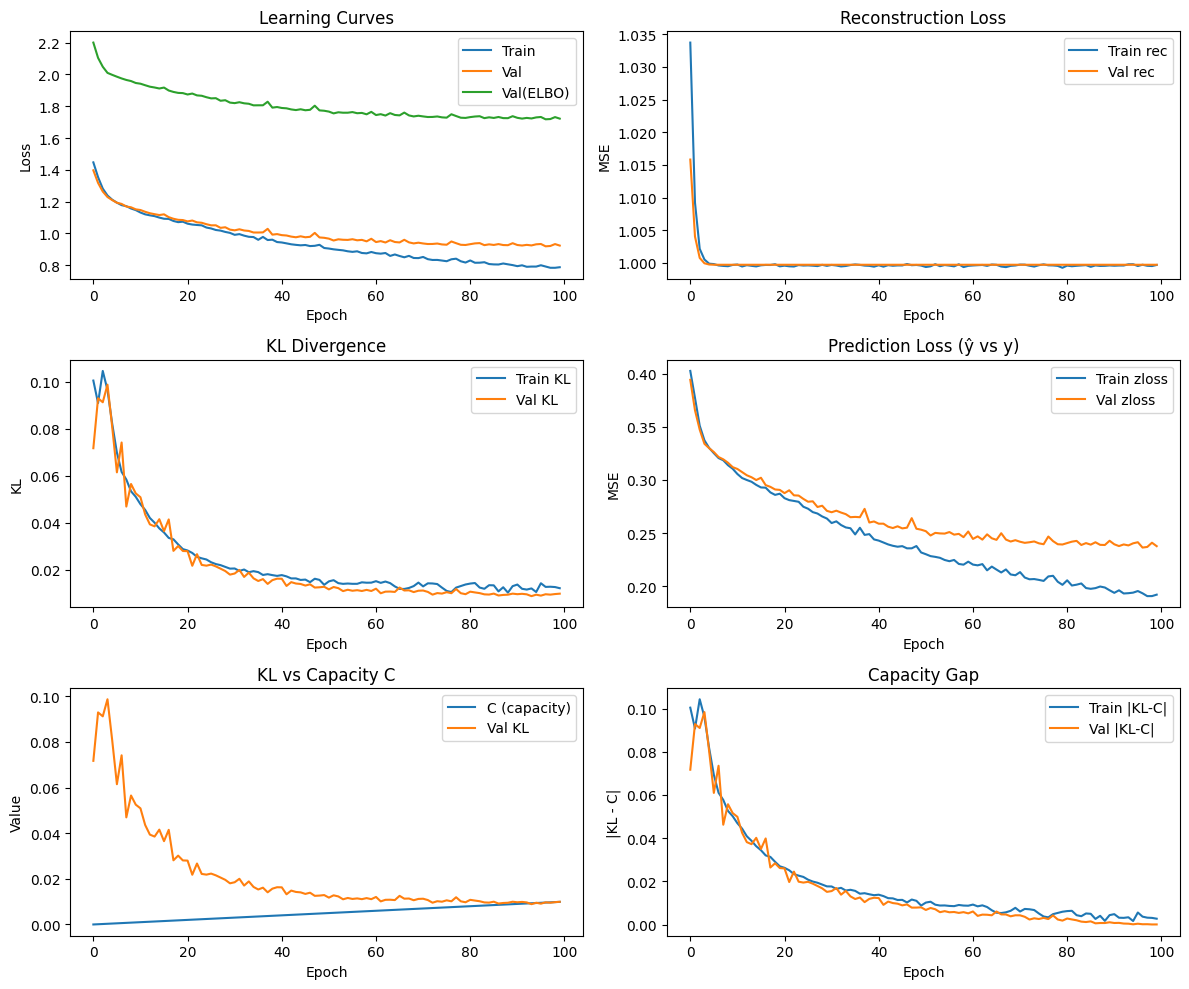

In [17]:
plot_all_curves(
    train_hist,
    val_hist,
    elbo_val_hist,
    train_rec_hist,
    val_rec_hist,
    train_kl_hist,
    val_kl_hist,
    train_z_hist,
    val_z_hist,
    C_values,
    train_capgap_hist,
    val_capgap_hist,
)

In [16]:
state = torch.load(best_path, map_location=device)
model.load_state_dict(state)
model.eval()  # 評価モード

eval_dl = torch.utils.data.DataLoader(
    val_ds,  # 元の val_ds でOK
    batch_size=8192,  # 好きなサイズ
    shuffle=False,
    num_workers=0,  # ★シングルプロセス
    pin_memory=False,  # ★不要
    persistent_workers=False,  # ★絶対 False
    drop_last=False,
)

ys, yhats = [], []
with torch.inference_mode():
    for xg, xd, y in eval_dl:
        xg, xd = xg.to(device), xd.to(device)
        _, _, _, yhat = model(xg, xd)
        ys.append(y.cpu().numpy())
        yhats.append(yhat.cpu().numpy())
ys = np.concatenate(ys)
yhats = np.concatenate(yhats)
mae = mean_absolute_error(ys, yhats)
r2 = r2_score(ys, yhats)

plt.figure()
plt.scatter(ys, yhats, s=8, alpha=0.4)
lims = [min(ys.min(), yhats.min()), max(ys.max(), yhats.max())]
plt.plot(lims, lims)
plt.xlabel("True y")
plt.ylabel("Predicted ŷ")
plt.title(f"Parity Plot (Val)  MAE={mae:.3f}, R²={r2:.3f}")
plt.tight_layout()
plt.show()

RuntimeError: Error(s) in loading state_dict for RobertaModel:
	Missing key(s) in state_dict: "embeddings.word_embeddings.weight", "embeddings.position_embeddings.weight", "embeddings.token_type_embeddings.weight", "embeddings.LayerNorm.weight", "embeddings.LayerNorm.bias", "encoder.layer.0.attention.self.query.weight", "encoder.layer.0.attention.self.query.bias", "encoder.layer.0.attention.self.key.weight", "encoder.layer.0.attention.self.key.bias", "encoder.layer.0.attention.self.value.weight", "encoder.layer.0.attention.self.value.bias", "encoder.layer.0.attention.output.dense.weight", "encoder.layer.0.attention.output.dense.bias", "encoder.layer.0.attention.output.LayerNorm.weight", "encoder.layer.0.attention.output.LayerNorm.bias", "encoder.layer.0.intermediate.dense.weight", "encoder.layer.0.intermediate.dense.bias", "encoder.layer.0.output.dense.weight", "encoder.layer.0.output.dense.bias", "encoder.layer.0.output.LayerNorm.weight", "encoder.layer.0.output.LayerNorm.bias", "encoder.layer.1.attention.self.query.weight", "encoder.layer.1.attention.self.query.bias", "encoder.layer.1.attention.self.key.weight", "encoder.layer.1.attention.self.key.bias", "encoder.layer.1.attention.self.value.weight", "encoder.layer.1.attention.self.value.bias", "encoder.layer.1.attention.output.dense.weight", "encoder.layer.1.attention.output.dense.bias", "encoder.layer.1.attention.output.LayerNorm.weight", "encoder.layer.1.attention.output.LayerNorm.bias", "encoder.layer.1.intermediate.dense.weight", "encoder.layer.1.intermediate.dense.bias", "encoder.layer.1.output.dense.weight", "encoder.layer.1.output.dense.bias", "encoder.layer.1.output.LayerNorm.weight", "encoder.layer.1.output.LayerNorm.bias", "encoder.layer.2.attention.self.query.weight", "encoder.layer.2.attention.self.query.bias", "encoder.layer.2.attention.self.key.weight", "encoder.layer.2.attention.self.key.bias", "encoder.layer.2.attention.self.value.weight", "encoder.layer.2.attention.self.value.bias", "encoder.layer.2.attention.output.dense.weight", "encoder.layer.2.attention.output.dense.bias", "encoder.layer.2.attention.output.LayerNorm.weight", "encoder.layer.2.attention.output.LayerNorm.bias", "encoder.layer.2.intermediate.dense.weight", "encoder.layer.2.intermediate.dense.bias", "encoder.layer.2.output.dense.weight", "encoder.layer.2.output.dense.bias", "encoder.layer.2.output.LayerNorm.weight", "encoder.layer.2.output.LayerNorm.bias", "encoder.layer.3.attention.self.query.weight", "encoder.layer.3.attention.self.query.bias", "encoder.layer.3.attention.self.key.weight", "encoder.layer.3.attention.self.key.bias", "encoder.layer.3.attention.self.value.weight", "encoder.layer.3.attention.self.value.bias", "encoder.layer.3.attention.output.dense.weight", "encoder.layer.3.attention.output.dense.bias", "encoder.layer.3.attention.output.LayerNorm.weight", "encoder.layer.3.attention.output.LayerNorm.bias", "encoder.layer.3.intermediate.dense.weight", "encoder.layer.3.intermediate.dense.bias", "encoder.layer.3.output.dense.weight", "encoder.layer.3.output.dense.bias", "encoder.layer.3.output.LayerNorm.weight", "encoder.layer.3.output.LayerNorm.bias", "encoder.layer.4.attention.self.query.weight", "encoder.layer.4.attention.self.query.bias", "encoder.layer.4.attention.self.key.weight", "encoder.layer.4.attention.self.key.bias", "encoder.layer.4.attention.self.value.weight", "encoder.layer.4.attention.self.value.bias", "encoder.layer.4.attention.output.dense.weight", "encoder.layer.4.attention.output.dense.bias", "encoder.layer.4.attention.output.LayerNorm.weight", "encoder.layer.4.attention.output.LayerNorm.bias", "encoder.layer.4.intermediate.dense.weight", "encoder.layer.4.intermediate.dense.bias", "encoder.layer.4.output.dense.weight", "encoder.layer.4.output.dense.bias", "encoder.layer.4.output.LayerNorm.weight", "encoder.layer.4.output.LayerNorm.bias", "encoder.layer.5.attention.self.query.weight", "encoder.layer.5.attention.self.query.bias", "encoder.layer.5.attention.self.key.weight", "encoder.layer.5.attention.self.key.bias", "encoder.layer.5.attention.self.value.weight", "encoder.layer.5.attention.self.value.bias", "encoder.layer.5.attention.output.dense.weight", "encoder.layer.5.attention.output.dense.bias", "encoder.layer.5.attention.output.LayerNorm.weight", "encoder.layer.5.attention.output.LayerNorm.bias", "encoder.layer.5.intermediate.dense.weight", "encoder.layer.5.intermediate.dense.bias", "encoder.layer.5.output.dense.weight", "encoder.layer.5.output.dense.bias", "encoder.layer.5.output.LayerNorm.weight", "encoder.layer.5.output.LayerNorm.bias", "pooler.dense.weight", "pooler.dense.bias". 
	Unexpected key(s) in state_dict: "g1.weight", "g1.bias", "g2.weight", "g2.bias", "p1.weight", "p1.bias", "p2.weight", "p2.bias", "fc.weight", "fc.bias", "mu.weight", "mu.bias", "lv.weight", "lv.bias", "d1.weight", "d1.bias", "d2.weight", "d2.bias", "head.0.weight", "head.0.bias", "head.3.weight", "head.3.bias". 

# How to eval from loading the model

In [19]:
# # 1. Build the model and load the trained weights
# model = GeneDrugVAE(gene_dim, drug_dim=768, proj_dim=256, hidden=512, latent=128).to(device)
# model.load_state_dict(torch.load("models/gdsc/gdsc_last.pt", map_location=device))
# model.eval()  # set to evaluation mode

# # 2. Extract latent representations (μ) for all samples
# mus = []
# with torch.no_grad():  # disable gradient computation
#     for xg, xd, _ in dl:   # ignore y (IC50), only need xg and xd
#         xg = xg.to(device, non_blocking=True)
#         xd = xd.to(device, non_blocking=True)
#         mu, lv = model.encode(xg, xd)   # encode gene + drug into latent space
#         mus.append(mu.cpu().numpy())    # collect μ on CPU

# # Concatenate all latent vectors into one array
# Z_mu = np.concatenate(mus, axis=0)
# print("Latent shape:", Z_mu.shape)

In [20]:
# # ---------- 1) 全サンプルの μ をバッチで抽出 ----------
# model.eval()
# mus = []
# with torch.no_grad():
#     # 推論用 DataLoader（shuffle=False）
#     infer_dl = DataLoader(ds, batch_size=8192, shuffle=False, num_workers=0)
#     for xg, xd, y in tqdm(infer_dl, desc="Encode (μ)", leave=False):
#         xg = xg.to(device, non_blocking=True)
#         xd = xd.to(device, non_blocking=True)
#         mu, logvar = model.encode(xg, xd)  # GeneDrugVAE で encode を実装している前提
#         mus.append(mu.cpu().numpy())

# Z_mu = np.concatenate(mus, axis=0)  # (N, latent)

In [21]:
# # 可視化用メタ：薬ラベル & Z_score（元の ds に対応する順序を確保）
# # cellline_small の順序が ds と一致している前提（Dataset 内でそのまま index を使っている実装ならOK）
# meta_df = cellline_small.reset_index(drop=True).copy()
# # NAME が無い場合は SMILES を代用
# drug_label = meta_df["NAME"] if "NAME" in meta_df.columns else meta_df["SMILES"]
# zscore = meta_df["Z_score"].values
# cellline = meta_df["COSMIC_ID"]

In [22]:
# X0 = StandardScaler(with_mean=True, with_std=True).fit_transform(Z_mu)
# X = (
#     PCA(n_components=min(100, X0.shape[1]), random_state=42)
#     .fit_transform(X0)
#     .astype("float32")
# )

# umap2d = umap.UMAP(
#     n_neighbors=40,
#     min_dist=0.05,
#     metric="cosine",
#     init="spectral",
#     densmap=True,
#     random_state=42,
#     low_memory=True,
#     verbose=True,
# ).fit_transform(X)

In [23]:
# plt.figure()
# sc = plt.scatter(umap2d[:, 0], umap2d[:, 1], s=6, c=zscore, alpha=0.7)
# cb = plt.colorbar(sc)
# cb.set_label("Z_score")
# plt.xlabel("UMAP 1")
# plt.ylabel("UMAP 2")
# plt.title("UMAP colored by Z_score")
# plt.tight_layout()
# plt.show()

In [24]:
# # 入力: umap2d (N,2), drug_label (N,), zscore (N,)
# labs = pd.Series(drug_label).astype(str).str.strip().values
# z = np.asarray(zscore, dtype=float)

# # 座標で集約（丸めて同一点判定）
# xy = np.round(umap2d, 6)
# df = pd.DataFrame({"x": xy[:, 0], "y": xy[:, 1], "drug": labs, "z": z})

# # 各座標で「z が最小の薬」を代表に採用（効きが強い薬）
# idx = df.groupby(["x", "y"])["z"].idxmin()
# rep = df.loc[idx].reset_index(drop=True)  # x,y,drug,z が 1行/座標

# # 可視化（Top-20 + Other）
# vc = rep["drug"].value_counts()
# top_k = 20
# top = list(vc.head(top_k).index)

# cmap = plt.colormaps.get_cmap("tab20")
# colors = {d: cmap(i / (top_k - 1)) for i, d in enumerate(top)}
# other_color = (0.5, 0.5, 0.5, 0.25)

# plt.figure(figsize=(9, 7))
# # Otherを下地に
# m_other = ~rep["drug"].isin(top)
# plt.scatter(
#     rep.loc[m_other, "x"],
#     rep.loc[m_other, "y"],
#     s=6,
#     alpha=0.30,
#     color=other_color,
#     rasterized=True,
#     zorder=1,
#     label="Other",
#     edgecolors="none",
# )
# # Top-20 を重ねる
# for d in top:
#     m = rep["drug"].values == d
#     if m.any():
#         plt.scatter(
#             rep.loc[m, "x"],
#             rep.loc[m, "y"],
#             s=12,
#             alpha=0.95,
#             color=colors[d],
#             label=d,
#             rasterized=True,
#             zorder=3,
#             edgecolors="none",
#         )

# plt.xlabel("UMAP 1")
# plt.ylabel("UMAP 2")
# plt.title("UMAP – winner-takes-all by drug (min Z_score)")
# plt.legend(
#     bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=8, frameon=False, ncol=2
# )
# plt.tight_layout()
# plt.show()

In [25]:
# labs = pd.Series(drug_label).astype(str).str.strip().values
# drug = "Cisplatin"  # 例

# m = labs == drug
# plt.figure(figsize=(7, 6))
# plt.hexbin(umap2d[m, 0], umap2d[m, 1], gridsize=80, mincnt=1, norm=LogNorm())
# cb = plt.colorbar()
# cb.set_label("count (log)")
# plt.title(f"UMAP density – {drug}")
# plt.xlabel("UMAP 1")
# plt.ylabel("UMAP 2")
# plt.tight_layout()
# plt.show()